In [ ]:
## Install these packages if needeed
%pip install pandas
%pip install ydata-profiling
%pip install -U scikit-learn

### IMPORTS
---

In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_csv, DataFrame
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from src.utils import get_model, train_model, test_model, save_model

import warnings 
warnings. filterwarnings('ignore')

### DATA
---

In [2]:
acme = read_csv(filepath_or_buffer='./ACME-HappinessSurvey2020.csv')
acme.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [3]:
acme.columns

Index(['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')

In [4]:
acme.shape

(126, 7)

In [5]:
acme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [6]:
acme[[f'X{index}' for index in range(1, 7)]].describe(include='all')

,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
acme.value_counts(subset=['Y'], normalize=True, dropna=True).to_frame()

,0
Y,
1,0.547619
0,0.452381


### EDA
----

In [8]:
profile = ProfileReport(df=acme)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file(output_file='acme_eda.html', silent=False)

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### MODELLING
---

#### Model Selection

In [ ]:
# PARAMETERS 
## [PREDICT]
TYPE_TASK = 'classifier'
TARGET = 'Y'

##[SPLIT]
TEST_SIZE = 0.2

## [REPRODUCIBILITY]
SEED = 42

X, y = acme.drop(TARGET, axis=1), acme[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=y)
 
print(f"## TRAIN TEST SPLIT: \n\t TRAIN : {X_train.shape}\n\t TEST : {X_test.shape}")

## TRAIN TEST SPLIT: 
	 TRAIN : (100, 6)
	 TEST : (26, 6)


In [ ]:
def run_experiment(partitions : tuple, task : str) -> tuple:
    X_train, X_test, y_train, y_test = partitions
    
    models = get_model(task=task)

    experiment = []
    fitted_models = {}
    for model in models:
        try:
            (train_scores, _), fitted_model, duration = train_model(
                model = model,
                X = X_train,
                y = y_train,
                scoring=['accuracy']

            )

            (test_scores, _) = test_model(
                model = fitted_model,
                X = X_test,
                y = y_test,
                scoring=['accuracy']
            )
    
            experiment.append([model.__class__.__name__, train_scores['accuracy'], test_scores['accuracy'], duration])
            fitted_models[model.__class__.__name__] = fitted_model
        except Exception:
            ...
        
    result = DataFrame(data=experiment, columns=['MODEL', 'TRAIN ACC', 'TEST ACC', 'DURATION (SECONDS)'])
    result.sort_values(by='TEST ACC', ascending=False, inplace=True)
    
    return result,fitted_models

##RUN
result, _ = run_experiment(
    partitions=(X_train, X_test, y_train, y_test),
    task=TYPE_TASK,
)
result

,MODEL,TRAIN ACC,TEST ACC,DURATION (SECONDS)
3,DecisionTreeClassifier,0.96,0.692308,0.000000
1,CategoricalNB,0.60,0.692308,0.014554
14,LinearSVC,0.59,0.653846,0.019141
19,NearestCentroid,0.60,0.653846,0.011743
10,KNeighborsClassifier,0.67,0.615385,0.015287
26,RidgeClassifierCV,0.58,0.615385,0.008418
25,RidgeClassifier,0.58,0.615385,0.015331
24,RandomForestClassifier,0.96,0.615385,0.544533
15,LogisticRegression,0.57,0.615385,0.024405
13,LinearDiscriminantAnalysis,0.58,0.615385,0.014361


#### Feature selection - SequentialFeatureSelector + CATEGORICALNB

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import CategoricalNB
from sklearn.base import BaseEstimator

def select_features(X : DataFrame, y: DataFrame, estimator: BaseEstimator) -> SequentialFeatureSelector:
    return SequentialFeatureSelector(estimator=estimator, n_features_to_select="auto",scoring='accuracy', direction="backward").fit(X, y)


fs = select_features(X=X_train, y=y_train, estimator=CategoricalNB())

print(f"MOST IMPORTANT FEATURES: {fs.get_feature_names_out()}")

MOST IMPORTANT FEATURES: ['X1' 'X2' 'X5']


In [ ]:
X_train, X_test = list(map(fs.transform, [X_train, X_test]))
print(X_train.shape, X_test.shape)

(100, 3) (26, 3)


In [ ]:
results, fitted_models = run_experiment(partitions=[X_train,X_test, y_train, y_test], task=TYPE_TASK)
results

,MODEL,TRAIN ACC,TEST ACC,DURATION (SECONDS)
25,RandomForestClassifier,0.82,0.846154,0.717154
3,DecisionTreeClassifier,0.82,0.846154,0.008118
6,ExtraTreesClassifier,0.82,0.846154,0.241091
11,LabelPropagation,0.82,0.846154,0.017164
12,LabelSpreading,0.82,0.846154,0.000000
8,GaussianProcessClassifier,0.75,0.807692,0.012521
24,RadiusNeighborsClassifier,0.70,0.769231,0.014117
5,ExtraTreeClassifier,0.82,0.769231,0.008349
20,NuSVC,0.79,0.769231,0.002637
10,KNeighborsClassifier,0.71,0.769231,0.012141


#### Feature importance -- DECISION TREE CLASSIFIER

In [ ]:
from sklearn.inspection import permutation_importance

BEST_FITTED_MODEL = fitted_models['DecisionTreeClassifier']
r = permutation_importance(BEST_FITTED_MODEL, X=X_train, y=y_train,
                           n_repeats=30,
                           random_state=SEED,
                           scoring='accuracy')

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{fs.get_feature_names_out()[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

X5      0.250 +/- 0.043
X1      0.201 +/- 0.035
X2      0.193 +/- 0.034


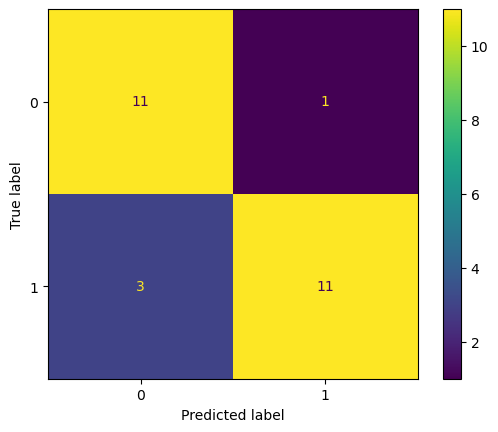

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = BEST_FITTED_MODEL.predict(X_test)
conf_mat  = confusion_matrix(y_true=y_test, y_pred=predictions)

ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()

#### SAVE MODEL
---

In [ ]:
save_model(fitted_model=BEST_FITTED_MODEL, filepath='acme_best_model.jb')